<a href="https://colab.research.google.com/github/Soomro2023/Project-L3/blob/main/Project_L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1. Import modules


In [109]:
%matplotlib inline
from google.colab import files
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#upload file
upload = files.upload()

Saving potential-talents.xlsx to potential-talents.xlsx


In [4]:
# read the uploaded file
talent_potential_df = pd.read_excel('potential-talents.xlsx')

# Step 2. Exploratory Data Analysis (EDA)

In [5]:
# first five rows
talent_potential_df.head(5)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [6]:
# last five rows
talent_potential_df.tail(5)

,id,job_title,location,connection,fit
99,100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN
103,104,Director Of Administration at Excellence Logging,"Katy, Texas",500+,NaN


In [5]:
# Data info
talent_potential_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


The fit column has no non-null. We need to drop this column for now as this is the coulmn we need to predict.

In [9]:
fit = talent_potential_df['fit']
tp_data = talent_potential_df.drop('fit', axis = 1)
tp_data.head(2)

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+


### Analyzing uniqueness in coulmns

In [12]:
for col in tp_data.columns:
  print(f"{tp_data[col].nunique()} unique values in {col}")

104 unique values in id
52 unique values in job_title
41 unique values in location
33 unique values in connection


### There are 52 unique values in the job_title column.

### id column has all unique values, so this column should be dropped before analyzing duplicated rows.

### Analyzing duplicated rows

In [23]:
# drop id column
ID = tp_data['id']
tp_data_new = tp_data.copy()
tp_data_new = tp_data_new.drop('id', axis = 1)
print(f'There are {tp_data_new.duplicated().sum()} duplicated rows')


There are 51 duplicated rows


### There are 51 duplicated rows, and that should be dropped from the data.

In [66]:
# drop duplicated rows
tp_data_new = tp_data_new.drop_duplicates()

# add 'id' column to the data

tp_data_sorted = pd.concat([ID, tp_data_new], axis = 1).dropna(axis = 0)

# reseting index

tp_data_sorted = tp_data_sorted.reset_index(drop = True)

# Step 3. NLP

### 3.1 Text cleaning by removing punctuations, numbers, and special charachters

In [67]:
tp_data_sorted = tp_data_sorted.replace({'job_title' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " ", r'[0-9]' : " "}}, regex=True)
# tp_data_sorted = tp_data_sorted.replace({'job_title' : { r"0-9" : " "}}, regex=True)
tp_data_sorted = tp_data_sorted.replace({'location' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " "}}, regex=True)

### 3.2 Converting all text in lowecase

In [68]:
tp_data_sorted['job_title'] = tp_data_sorted['job_title'].str.lower()
tp_data_sorted['location'] = tp_data_sorted['location'].str.lower()

### 3.3 Removing stopwords (i.e., and, or, at, etc) and lemmatizing the text

In [69]:
def lemmatizing(df, col):
  lem = WordNetLemmatizer()
  for i in range(len(df)):
    words_token_with_sw    = nltk.word_tokenize(df[col][i])
    words_token_without_sw = [lem.lemmatize(word) for word in words_token_with_sw if word not in set(stopwords.words('english'))]
    df[col][i]             = ' '.join(words_token_without_sw)

print('Job title before removing stopwprds:\n', tp_data_sorted.job_title.head(1))
print("-" * 120)

# Remove stop words and lemmatize words in cleaned job title
lemmatizing(tp_data_sorted, 'job_title')

print('Job title after removing stopwprds:\n', tp_data_sorted.job_title.head(1))
print("-" * 120)
tp_data_sorted.head(2)



Job title before removing stopwprds:
 0         c t  bauer college of business graduate  magna cum laude  and aspiring human resources professional
Name: job_title, dtype: object
------------------------------------------------------------------------------------------------------------------------
Job title after removing stopwprds:
 0    c bauer college business graduate magna cum laude aspiring human resource professional
Name: job_title, dtype: object
------------------------------------------------------------------------------------------------------------------------


,id,job_title,location,connection
0,1,c bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85
1,2,native english teacher epik english program korea,kanada,500+


### 3.4 Wod Embedding

Reference : <a href="https://www.turing.com/kb/guide-on-word-embeddings-in-nlp"> A Guide on Word Embeddings in NLP</a>

### I use two word embedding techniques:
1. **`TF-IDF`**: a statistical measure used to determine the mathematical significance of words in documents.

2. **`BERT`**: use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text.

### 3.4.1 TF-IDF

Number of unique features:  178
First 10 features:  ['administration' 'administrative' 'admission' 'advisory' 'always'
 'america' 'analyst' 'analytics' 'army' 'art']
Shape of Tfidf vector:  (53, 178)


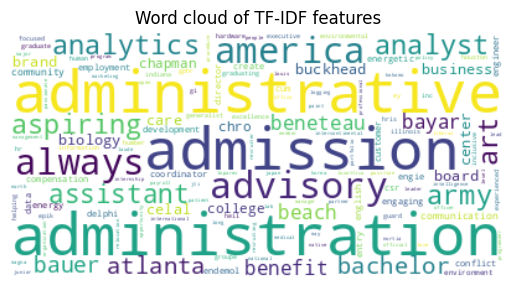

In [124]:
# vectorize the job_title column
# first convert the job_title column into a list then vectorize it

job_title_list = list(tp_data_sorted['job_title'])

# Vectorize job_title_list
vectorizer = TfidfVectorizer().fit(job_title_list)
X = vectorizer.transform(job_title_list)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

print("Number of unique features: ", len(feature_names))
print("First 10 features: ", feature_names[:10])

# Convert job titles into arrays
tfidf_vector = X.toarray()
print("Shape of Tfidf vector: ", tfidf_vector.shape)
text = " ".join( word for word in feature_names)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud of TF-IDF features")
plt.show()

### Two key words are given: **`aspiring human resources`** **OR** **`seeking human resources`**

### we use one of keywords to find its similarity in the text.

In [125]:
from ast import keyword
key_words = pd.DataFrame({'key_word':['aspiring human resources', 'seeking human resources'] })
lemmatizing(key_words, 'key_word')
selected_keyword = key_words.key_word[0]
selected_keyword

'aspiring human resource'

Generate cosine-similarity for TF-IDF

In [138]:
# vectorize the selected key word
keyword_vector = vectorizer.transform([selected_keyword])
keyword_vector = keyword_vector.toarray()
cosine_sim_score = cosine_similarity(tfidf_vector, keyword_vector)
tp_data_sorted['TF-IDF_fit'] = cosine_sim_score

In [137]:
# Top five matching TF-IDF features scores with the selected key word
tp_data_sorted.sort_values(by ='TF-IDF_fit', ascending = False).head()

,id,job_title,location,connection,TF-IDF_fit
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.773149
45,97,aspiring human resource professional,kokomo indiana area,71,0.773149
5,6,aspiring human resource specialist,greater new york city area,1,0.682828
21,73,aspiring human resource manager seeking internship human resource,houston texas area,7,0.623759
12,27,aspiring human resource management student seeking internship,houston texas area,500+,0.440969


In [140]:
# the lowest five matching TF-IDF features scores with the selected key word
tp_data_sorted.sort_values(by ='TF-IDF_fit', ascending = False).tail()

,id,job_title,location,connection,TF-IDF_fit
31,83,hr manager endemol shine north america,los angeles california,268,0.0
10,12,svp chro marketing communication csr officer engie houston woodland energy gphr sphr,houston texas area,500+,0.0
28,80,junior me engineer information system,myrtle beach south carolina area,52,0.0
1,2,native english teacher epik english program korea,kanada,500+,0.0
52,104,director administration excellence logging,katy texas,500+,0.0


3.4.2 Bidirectional Encoder Representations from Transformers (BERT)

In [142]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=0db15479c57be7ab0363e00f41d8bcf31a779d98ac41f602ca2ef448125d41e1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [143]:
from sentence_transformers import SentenceTransformer
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [148]:
# Convert job titles into BERT embedded vectors
bert_job_title_embedded_vector = bert_model.encode(list(tp_data_sorted.job_title))

# Convert selected key word into a BERT embedded vector
bert_sel_keyword_embedded_vector = bert_model.encode([selected_keyword])

Generate cosine-similarity for BERT

In [149]:
cosine_sim_BERT = cosine_sim_score = cosine_similarity(bert_job_title_embedded_vector, bert_sel_keyword_embedded_vector)
tp_data_sorted['BERT_fit'] = cosine_sim_BERT

In [150]:
# Top five matching BERT scores with the selected key word
tp_data_sorted.sort_values(by ='BERT_fit', ascending = False).head()

,id,job_title,location,connection,TF-IDF_fit,BERT_fit
5,6,aspiring human resource specialist,greater new york city area,1,0.682828,0.955137
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.773149,0.948828
45,97,aspiring human resource professional,kokomo indiana area,71,0.773149,0.948828
30,82,aspiring human resource professional energetic team focused leader,austin texas area,174,0.338278,0.885530
47,99,seeking human resource position,las vegas nevada area,48,0.296745,0.849293


In [151]:
# the lowest five matching BERT scores with the selected key word
tp_data_sorted.sort_values(by ='BERT_fit', ascending = False).tail()

,id,job_title,location,connection,TF-IDF_fit,BERT_fit
10,12,svp chro marketing communication csr officer engie houston woodland energy gphr sphr,houston texas area,500+,0.0,0.344135
33,85,rrp brand portfolio executive jti japan tobacco international,greater philadelphia area,500+,0.0,0.253621
44,96,student indiana university kokomo business management retail manager delphi hardware paint,lafayette indiana,19,0.0,0.230208
41,93,admission representative community medical center long beach,long beach california,9,0.0,0.181031
35,87,bachelor science biology victoria university wellington,baltimore maryland,40,0.0,0.136410


# To Do: Ranking???